100%|██████████| 10000/10000 [00:53<00:00, 185.26it/s]


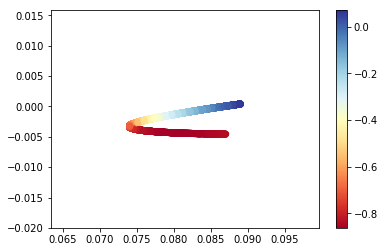

In [16]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm

''' Read: http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats '''

def symbol_to_path(symbol):
    return os.path.join("{}.csv".format(str(symbol)))

def dates_creator(start_date, end_date):
    dates = pd.date_range(start_date, end_date)
    return dates

def get_data(start, end, stocks):
    dates = dates_creator(start, end)
    df = pd.DataFrame(index = dates)
    if 'SPY' not in stocks: # adding SPY as the main reference
        stocks.insert(0, 'SPY')
    for symbol in stocks:
        df_temp = pd.read_csv(symbol_to_path(symbol),
            index_col = 'Date',
            parse_dates = True,
            usecols = ['Date', 'Adj Close'],
            na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': symbol})
        df = df.join(df_temp)
    
        if symbol == 'SPY':
            df = df.dropna(subset = ['SPY'])
    return df

def normalize_data(df):
    return df / df.iloc[0,:]

def find_portfolio_statistics(allocs, df, gen_plot = False):
    dfcopy = df.copy()    
    '''
    Compute portfolio statistics:
    1) Cumulative return
    2) Daily return
    3) Average daily return
    4) Standard deviation of the daily returns
    5) (Annual) Sharpe Ratio
    6) Final value
    7) Total returns
    
    Parameters:
    -----------
    allocs: list of allocation fractions for each stock
            The sum must be equal to 1!
        example: allocs =  [0.0, 0.5, 0.35, 0.15]
    df: DataFrame with the data
    
    Optional:
    ---------
    gen_plot: if True, a plot with performance of the allocation
              compared to SPY500 will be shown.
    '''
    # Normalization
    df = (df / df.iloc[0])
    # Allocation of the resources
    df = df * allocs
    # Sum of the value of the resources
    df = df.sum(axis = 1)
    
    # Compute Portfolio Statistics
    
    # Cumulative return
    cumulative_return = (df.iloc[-1] / df.iloc[0]) - 1
    
    # Daily returns
    dailyreturns = (df.iloc[1:] / df.iloc[:-1].values) - 1
    average_daily_return = dailyreturns.mean(axis = 0)
    yearly_return = average_daily_return #* 252 # 252 days of trading in a year
    
    # Standard deviation of the daily returns
    std_daily_return = dailyreturns.std(axis = 0)
    
    # Sharpe Ratio
    sharpe_ratio = (252 ** (0.5)) * ((average_daily_return - 0) / std_daily_return)
    ending_value = df.iloc[-1]
    total_returns = average_daily_return*(252 / 252)
    if gen_plot == True:
    #Plot portfolio along SPY
        dfcopynormed = dfcopy['SPY'] / dfcopy['SPY'].iloc[0]
        ax = dfcopynormed.plot(title = 'Daily Portfolio Value and SPY', label = 'SPY')
        sumcopy = dfcopy.sum(axis = 1)
        normed = sumcopy/sumcopy.iloc[0]
        normed.plot(label='Portfolio Value', ax = ax)
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend(loc = 2)
        plt.show()
        
    
#     print('For allocation as follows:')
#     print(allocs)
#     print('Mean return:')
#     print(mean_return)
#     print('Standard deviation:')
#     print(std_return)
#     print('Annualized Sharpe ratio:')
#     print(sharpe_ratio)
   
    
    return yearly_return, std_daily_return, sharpe_ratio
    
def generate_random_portfolios(num_portfolios, stocks, include_SPY = False):
    start = '2018-05-18'
    end = '2019-05-17'
    
    df = get_data(start, end, stocks)
    df = df.drop('SPY', 1)
    
    # Number of stocks (-1 to not to include SPY)
    num_stocks = len(stocks) - 1
    # Initialization the final result matrix with zeros
    result_matrix = np.zeros([num_portfolios,3])
    for i in tqdm(range(num_portfolios)):
        random = np.random.random(num_stocks)
        allocs = random/ np.sum(random)
        mean_return, std_return, sharpe_ratio = find_portfolio_statistics(allocs, df, gen_plot = False)
        result_matrix[i, 0] = mean_return
        result_matrix[i, 1] = std_return
        result_matrix[i, 2] = sharpe_ratio
    return result_matrix

if __name__ == "__main__":
    
    stocks = ['SPY', 'INNT', 'NCTY', 'MBIO']
    
    result_matrix = generate_random_portfolios(10000, stocks)

    #convert results array to Pandas DataFrame
    results_frame = pd.DataFrame(result_matrix,columns=['ret','stdev','sharpe'])
 
     #create scatter plot coloured by Sharpe Ratio
    plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
    plt.colorbar()
    plt.show()
    